# Exploratory Data Analysis

---

This notebook explores the beer review data in a very general way.

In [1]:
%load_ext autoreload
%autoreload 1

import sys
sys.path.append('..')

import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Custom modules
from src import utils

# Paths
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
DATA_DIR = os.path.join(ROOT_DIR, "data")

# Constants
SEED = 42

In [2]:
err_msg = f"❌ Data not found at {DATA_DIR}! Please run `utils.download_data(DATA_URL) from the root"
assert os.path.exists(os.path.join(DATA_DIR, "reviews.feather")), err_msg
print(f"✅ Data found at .{DATA_DIR}/reviews.feather")

✅ Data found at ./Users/jonas-mika/epfl/coursework/projects/ada-2023-project-blackada/data/reviews.feather


## Data Loading

Let's load the data using the `utils.load_data` function. This notebook assumes that the data is already stored in the `data` directory as a `.feather` file.

In [3]:
# Load all reviews and a subset of reviews (100,000)
start = time.time()
reviews = utils.load_data(DATA_DIR)

print(f"Loaded {len(reviews)} reviews ✅ in {(time.time() - start):.2f}s.")

Loaded 2400935 reviews ✅ in 5.11s.


In [4]:
# Check that there are no missing values (NaNs)
missing_values = reviews.isna().sum()

err_msg = f"❌ There are {missing_values.sum()} missing values in the dataset!"
assert missing_values.sum() == 0, err_msg
print(f"✅ There are no missing values.")

✅ There are no missing values.


## General Statistics

Here we plot general statistics like some example reviews, the total number of samples and features.

In [5]:
# Show the first 5 rows of the data
reviews.head(3)

beer                                                                \
       id           name             style  abv nbr_ratings nbr_reviews   
0  142544          Régab   Euro Pale Lager  4.5           1           1   
1   19590  Barelegs Brew  English Pale Ale  4.5           4           4   
2   19590  Barelegs Brew  English Pale Ale  4.5           4           4   

  brewery                                                               \
       id                                       name          location   
0   37262  Societe des Brasseries du Gabon (SOBRAGA)             Gabon   
1   10093       Strangford Lough Brewing Company Ltd  Northern Ireland   
2   10093       Strangford Lough Brewing Company Ltd  Northern Ireland   

             ...                user                                review  \
  nbr_beers  ...              joined                   location appearance   
0         1  ... 2008-01-07 11:00:00  United States, Washington       3.25   
1         5  ... 2007-10-08 10:00:00    United States, New York       3.00   
2         5  ... 2005-05-18 10:00:00           Northern Ireland       4.00   

                                     \
  aroma palate taste overall rating   
0  2.75   3.25  2.75     3.0   2.88   
1  3.50   3.50  4.00     3.5   3.67   
2  3.50   3.50  4.00     3.5   3.73   

                                                                          
                                                text                date  
0  From a bottle, pours a piss yellow color with ... 2015-08-20 10:00:00  
1  Pours pale copper with a thin head that quickl... 2009-02-20 11:00:00  
2  500ml Bottle bought from The Vintage, Antrim..... 2006-03-13 11:00:00  

[3 rows x 24 columns]

The data was loaded and merged into a single data frame with multi-column indexing. Each row corresponds to a single review of a beer and denotes the user (`user`), beer (`beer`) and brewery (`brewery`) meta information, as well as the actual review data (`review`) in separate columns. For example, we can look at the keys individually for the first three reviews.

In [6]:
# Information about review for first 3 samples
reviews["review"].head(3)

,appearance,aroma,palate,taste,overall,rating,text,date
0,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ...",2015-08-20 10:00:00
1,3.00,3.50,3.50,4.00,3.5,3.67,Pours pale copper with a thin head that quickl...,2009-02-20 11:00:00
2,4.00,3.50,3.50,4.00,3.5,3.73,"500ml Bottle bought from The Vintage, Antrim.....",2006-03-13 11:00:00


In [7]:
# Meta-information on beer for first 3 samples
reviews["beer"].head(3)

,id,name,style,abv,nbr_ratings,nbr_reviews
0,142544,Régab,Euro Pale Lager,4.5,1,1
1,19590,Barelegs Brew,English Pale Ale,4.5,4,4
2,19590,Barelegs Brew,English Pale Ale,4.5,4,4


In [8]:
# Meta-information on user for first 3 samples
reviews["user"].head(3)

,id,name,nbr_ratings,nbr_reviews,joined,location
0,nmann08.184925,nmann08,7820,465,2008-01-07 11:00:00,"United States, Washington"
1,stjamesgate.163714,StJamesGate,2521,2504,2007-10-08 10:00:00,"United States, New York"
2,mdagnew.19527,mdagnew,1797,1143,2005-05-18 10:00:00,Northern Ireland


In [9]:
# Meta-information on brewery for first 3 samples
reviews["brewery"].head(3)

,id,name,location,nbr_beers
0,37262,Societe des Brasseries du Gabon (SOBRAGA),Gabon,1
1,10093,Strangford Lough Brewing Company Ltd,Northern Ireland,5
2,10093,Strangford Lough Brewing Company Ltd,Northern Ireland,5


As we see, for each review, we have information on the following features:
    
1. **Review** (`review`): Review Text, Ratings (Appearance, Aroma, Palate, Taste, Overall, Rating), Date
2. **User** (`user`): User ID, User Name, #Ratings, #Reviews, Joined Date, Location
3. **Beer** (`beer`): Beer ID, Beer Name, Beer Style, ABV (Alcohol By Volume), #Ratings, #Reviews
4. **Brewery** (`brewery`): Brewery ID, Brewery Name, Location, #Beers

Note, that we have dropped some columns in the original `beers.csv` that are not relevant for our analysis, e.g. the matching scores to the other brew rating website or averages of ratings/ reviews for each beer as we can compute them on the fly. Let's double check that this is the case.

In [10]:
# Quick sanity check
avg_rating = reviews[reviews[("beer", "name")] == "Barelegs Brew"][("review", "rating")].mean()

beers = pd.read_csv(os.path.join(DATA_DIR, "beers.csv"))
avg_rating2 = beers[beers["beer_name"] == "Barelegs Brew"]["avg_computed"].values[0]

err_msg = "❌ Average rating is not the same!"
assert avg_rating == avg_rating2, err_msg
print("✅ Checks out!")

✅ Checks out!


Let's now understand some basic statistics about the users, beers, breweries and reviews. We will tackle them one by one.

## Users

We look at the number of users, the number of reviews per user, the number of ratings per user and the number of reviews per user.

In [11]:
# Get the unique users
unique_users = reviews.user.drop_duplicates()
print(f"Number of unique users: {len(unique_users)}")

Number of unique users: 56354


Let's look at where the reviewers are from and how many reviews the top reviewers have written.

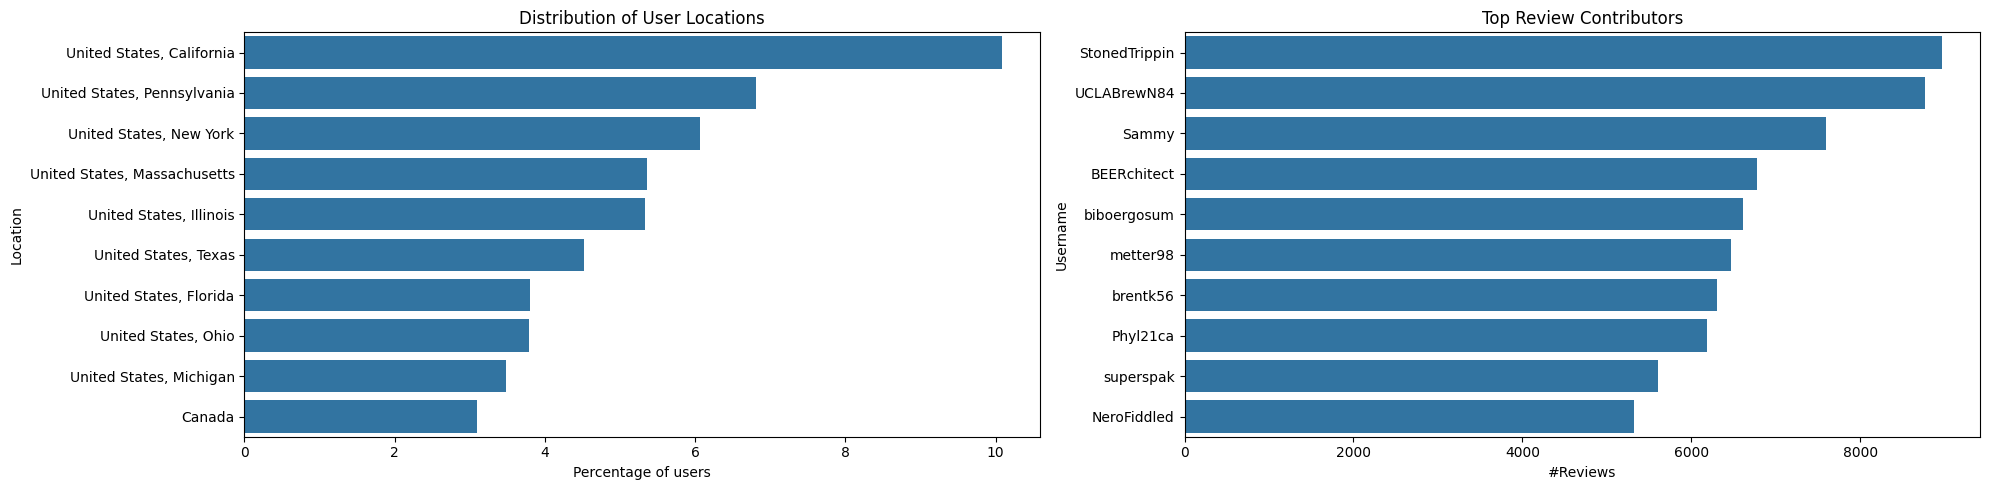

In [12]:
# Top 10 users with most reviews

# Get the distribution of the location of the users
user_location_dist = unique_users.location.value_counts(normalize=True) * 100
user_location_dist = user_location_dist.iloc[:10]

# Show the top review contributors
top_review_contributors = unique_users.sort_values(by="nbr_reviews", ascending=False).iloc[:10]

# Plot the data
fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
sns.barplot(x=user_location_dist.values, y=user_location_dist.index, ax=ax[0])
sns.barplot(x=top_review_contributors.nbr_reviews, y=top_review_contributors.name, ax=ax[1])

ax[0].set(xlabel="Percentage of users", ylabel="Location", title="Distribution of User Locations")
ax[1].set(xlabel="#Reviews", ylabel="Username", title="Top Review Contributors")

# Tight layout
plt.tight_layout()

Let's look at the distribution of the number of ratings and reviews for each user.

,count,mean,std,min,25%,50%,75%,max
#Ratings,56354.0,102.153973,372.863985,1.0,2.0,6.0,40.0,12046.0
#Reviews,56354.0,44.207669,224.764930,1.0,1.0,3.0,11.0,8970.0


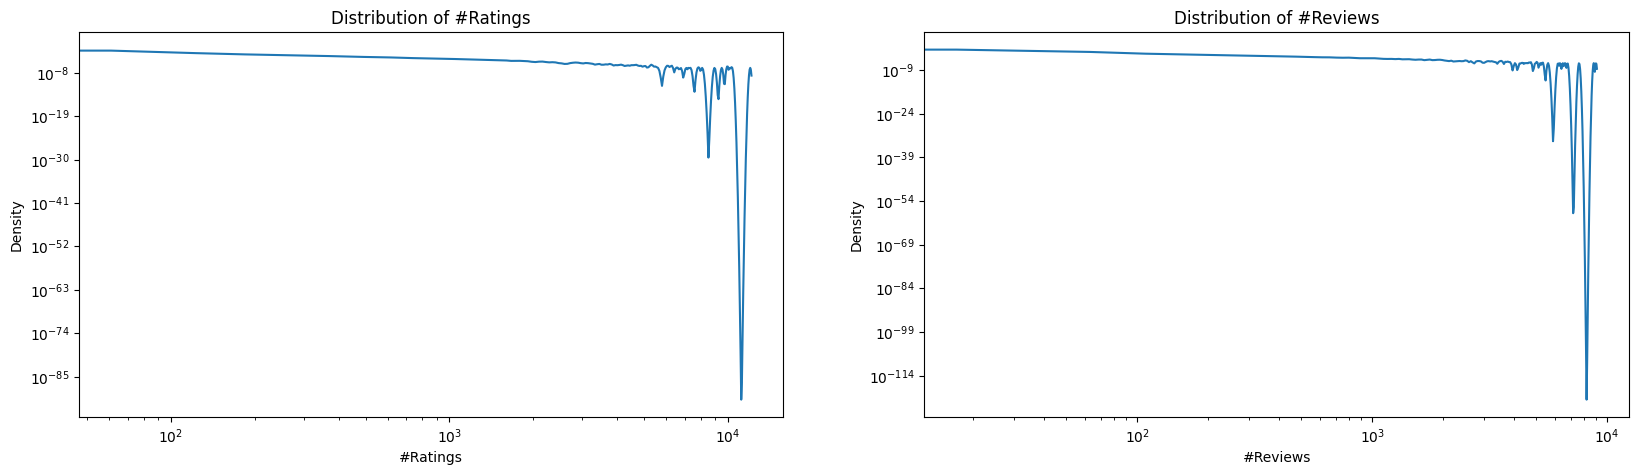

In [13]:
# Distribution of the number of ratings/ reviews per user
fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
sns.kdeplot(unique_users, x="nbr_ratings", ax=ax[0])
sns.kdeplot(unique_users, x="nbr_reviews", ax=ax[1])

nbr_ratings_stats = unique_users.nbr_ratings.describe()
nbr_reviews_stats = unique_users.nbr_reviews.describe()

ax[0].set(
    title="Distribution of #Ratings",
    xlabel="#Ratings",
    ylabel="Density",
    xscale="log",
    yscale="log"
)
ax[1].set(
    title="Distribution of #Reviews",
    xlabel="#Reviews",
    ylabel="Density",
    xscale="log",
    yscale="log"
)

# Show summary statistics
pd.DataFrame([nbr_ratings_stats, nbr_reviews_stats], index=["#Ratings", "#Reviews"])

Both distributions seem to be following a power law distribution. This means that there are a few users that have rated/ reviewed a lot of beers, while most users have rated/ reviewed only a few beers. Looking at the summary statistics we can see that on average a user has rated **~102** beers and reviewed **~44** beers. However, the median is much lower, half of the users not having rated more than **~6** and reviewed more than around **~3** beers. For our analysis this is actually good because it ensures a diverse crowd of users that review a beer.

### Breweries

In [14]:
# Get the unique beers
unique_breweries = reviews.brewery.drop_duplicates()

print(f"Number of unique breweries: {len(unique_breweries)}")

Number of unique breweries: 11117


Let's plot the 10 biggest breweries (by number of beers) and the 10 breweries with the most reviews.

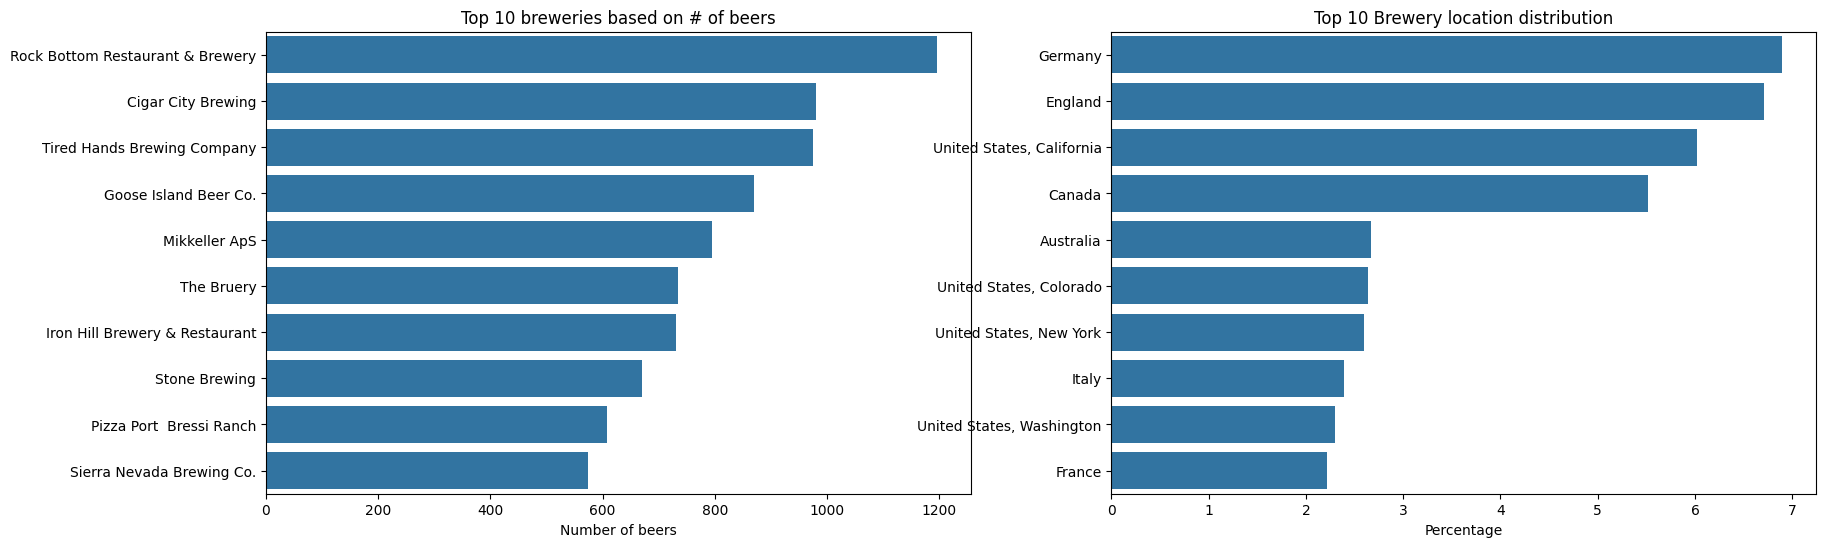

In [15]:
# Sort by nbr of beers
unique_breweries = unique_breweries.sort_values(by="nbr_beers", ascending=False)
top_breweries = unique_breweries.iloc[:10]

# Get the distribution of the location of the breweries
brewery_location_dist = unique_breweries.location.value_counts(normalize=True) * 100
brewery_location_dist = brewery_location_dist.iloc[:10]

# Plot the distribution of the location of the breweries
fig, ax = plt.subplots(ncols=2, figsize=(20, 6))
sns.barplot(x=top_breweries.nbr_beers, y=top_breweries.name, ax=ax[0])
sns.barplot(x=brewery_location_dist.values, y=brewery_location_dist.index, ax=ax[1])

# Set titles
ax[0].set_title("Top 10 breweries based on # of beers");
ax[1].set_title("Top 10 Brewery location distribution");

# Set labels
ax[0].set_xlabel("Number of beers");
ax[0].set_ylabel("");
ax[1].set_ylabel("");
ax[1].set_xlabel("Percentage");

Let's plot the distribution of the number of beers per brewery. We expect to see many small breweries with few beers and some large breweries with many beers.

,count,mean,std,min,25%,50%,75%,max
#Beers,11117.0,23.822344,44.616212,1.0,4.0,11.0,26.0,1196.0


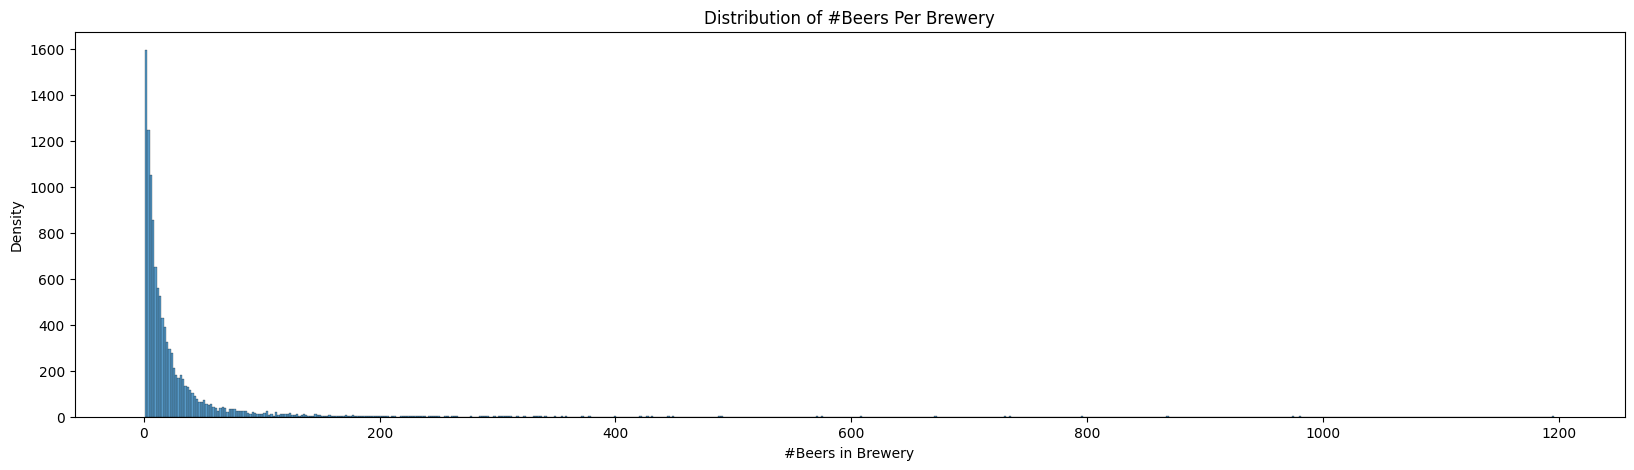

In [16]:
# Distribution of the number of ratings/ reviews per user
fig, ax = plt.subplots(figsize=(20, 5))
sns.histplot(unique_breweries, x="nbr_beers", ax=ax)

nbr_beers_stats = unique_breweries.nbr_beers.describe()

ax.set(
    title="Distribution of #Beers Per Brewery",
    xlabel="#Beers in Brewery",
    ylabel="Density",
)

# Show summary statistics
pd.DataFrame([nbr_beers_stats], index=["#Beers"])

As expected, the distribution of the number of beers per brewery is also heavy-tailed. On average, a brewery has **~24** beers, but a 1/4 of the breweries doesn't have more than 4 beers, and half of the breweries don't have more than **11** beeres.

### Beers

In [17]:
# Get the unique beers
unique_beers = reviews.beer.drop_duplicates()

print(f"Number of unique beer styles {len(unique_beers['style'].unique())}")
print(f"Number of unique breweries {len(unique_breweries)}")
print(f"Number of unique beers: {len(unique_beers)}")

Number of unique beer styles 104
Number of unique breweries 11117
Number of unique beers: 141833


Let's check for the most reviewed beers styles and beer brands in the data.

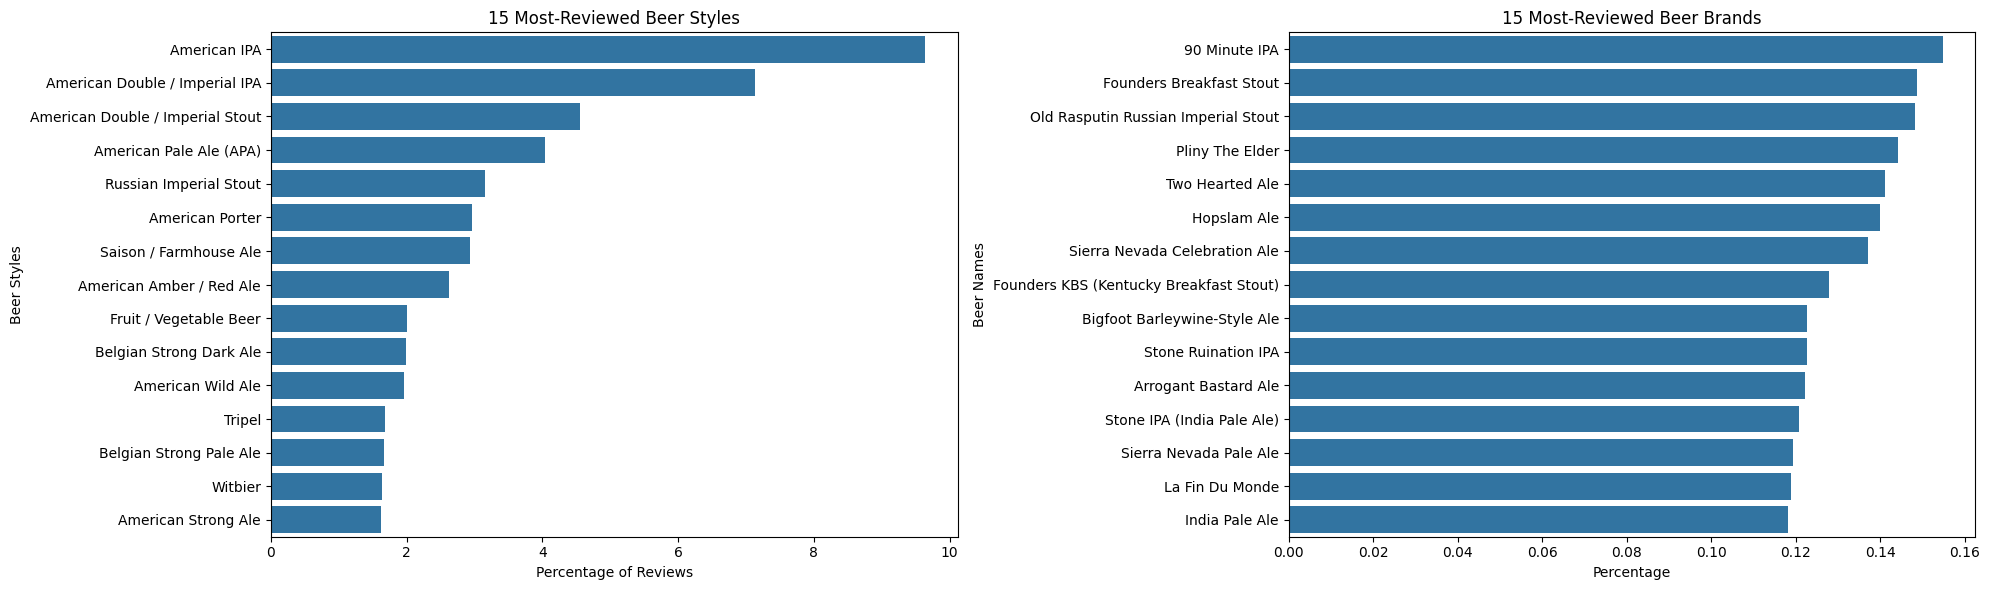

In [18]:
# Compute distribution of beer styles (%)
beer_style_dist = reviews["beer"]["style"].value_counts(normalize=True) * 100
beer_style_dist = beer_style_dist[:15]

# Compute distribution of beer names (%)
beer_name_dist = reviews["beer"]["name"].value_counts(normalize=True) * 100
beer_name_dist = beer_name_dist[:15]

# Using seaborn, plot all the computed distributions
fig, ax = plt.subplots(ncols=2, figsize=(20, 6), sharex=False)
sns.barplot(x=beer_style_dist.values, y=beer_style_dist.index, ax=ax[0])
sns.barplot(x=beer_name_dist.values, y=beer_name_dist.index, ax=ax[1])

ax[0].set(
    title="15 Most-Reviewed Beer Styles",
    xlabel="Percentage of Reviews",
    ylabel="Beer Styles",
)
ax[1].set(
    title="15 Most-Reviewed Beer Brands",
    xlabel="Percentage",
    ylabel="Beer Names",
)

# Set tight layout
plt.tight_layout()

### Reviews



In [19]:
# Let's show some example reviews
for i, review in reviews.head(10).review.iterrows():
    print(f"Review {i+1}: {review.text}")

Review 1: From a bottle, pours a piss yellow color with a fizzy white head.  This is carbonated similar to soda.The nose is basic.. malt, corn, a little floral, some earthy straw.  The flavor is boring, not offensive, just boring.  Tastes a little like corn and grain.  Hard to write a review on something so simple.Its ok, could be way worse.
Review 2: Pours pale copper with a thin head that quickly goes. Caramel, golden syrup nose. Taste is big toasty, grassy hops backed by dark fruit, candy corn and brack malts. Clingy. Dries out at the end with more hops. Brave, more going on that usual for this type.
Review 3: 500ml Bottle bought from The Vintage, Antrim...Poured a golden yellow / orange colour... White head poured quite thick and foamy and faded to thin layer...Aroma - Fruity (burnt orange, some apple hints), light maltiness, spicy hops, vanilla, some sea saltiness...Taste - Spicy / peppery hop notes, citrusy, light sweetness, grassy, slight creaminess, some bready notes...Feel - Q

,count,mean,std,min,25%,50%,75%,max
Character Lengths,2400935.0,679.421069,409.546961,42.0,405.0,582.0,836.0,5129.0
Word Lengths,2400935.0,118.655135,72.274044,1.0,70.0,102.0,146.0,967.0


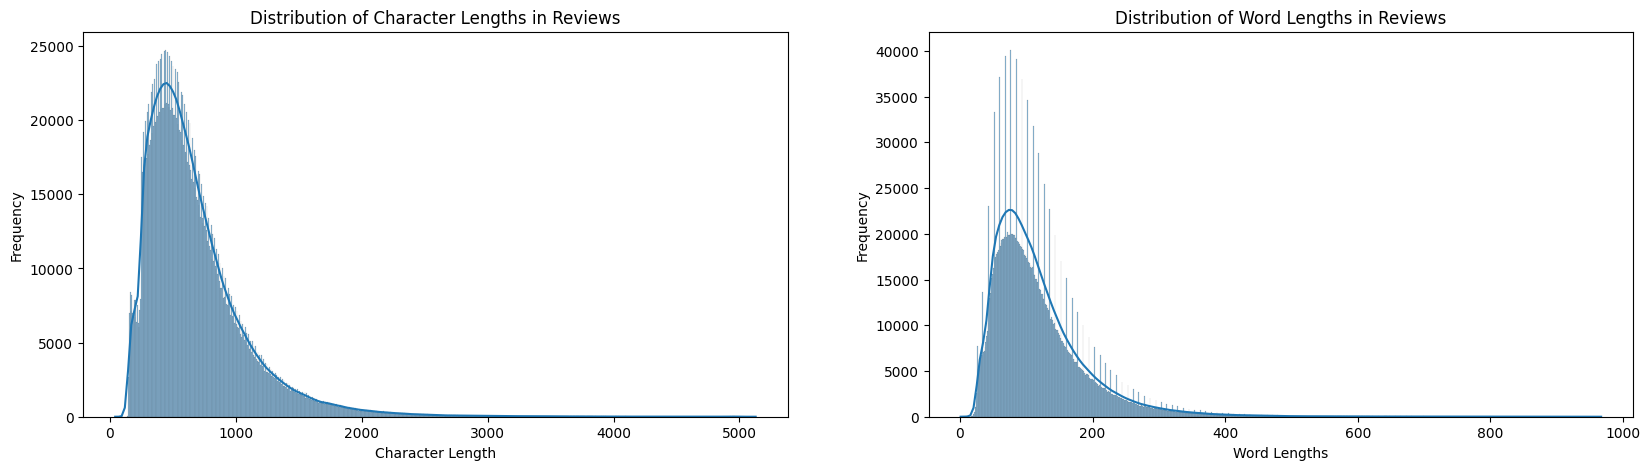

In [20]:
# Compute character and word lengths of reviews
character_lengths = reviews.review.text.str.len()
word_lengths = reviews.review.text.apply(lambda x: len(x.split()))

# Distribution of the number of ratings/ reviews per user
fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
sns.histplot(x=character_lengths, kde=True, ax=ax[0])
sns.histplot(x=word_lengths, kde=True, ax=ax[1])

character_lengths_stats = character_lengths.describe()
word_lengths_stats = word_lengths.describe()

ax[0].set(
    title="Distribution of Character Lengths in Reviews",
    xlabel="Character Length",
    ylabel="Frequency",
)
ax[1].set(
    title="Distribution of Word Lengths in Reviews",
    xlabel="Word Lengths",
    ylabel="Frequency",
)

# Show summary statistics
pd.DataFrame([character_lengths_stats, word_lengths_stats], index=["Character Lengths", "Word Lengths"])

We see that most reviews are around **~680 characters** and **~118 words** long. There is a slight right-skew in the distribution, meaning that there are some very long reviews. The very short reviews are probably not very helpful for our analysis as the numeric representation will not be meaningful. Let's look at those reviews and see if we have to deal with those reviews in some way.

In [21]:
# Show the shortest 0.1% of reviews (by character count)
shortest_character_length_reviews = reviews.review[character_lengths < np.percentile(character_lengths, 0.001)]

for i, review in shortest_character_length_reviews.head(5).iterrows():
    print(f"Review {i+1}: {review.text}")

Review 1945: **12/24/2016Bottle to snifter.Dark black, no head...right to lacing.Toasty barleyLight fruit finishA little Smokey.   From the scotch, **
Review 97812: ывв фыфффффффффффффффффффффффффффффффффффффффффффффффффффффффффффффффффффффф
Review 147548: Uncommon beer of the sour type. First it is a blend of beer aged 7 months in barrels of whiskey
Review 359065: Cool bottle. Definitely don't have to necessarily store this one in a dark place. Pale amber yellow (Hence pale lager
Review 420787: Ummm I literally just bought this so I could say I tried it, and I did drink them all.


In [22]:
# Show the shortest 0.1% of reviews (by word count)
shortest_word_length_reviews = reviews.review[word_lengths < np.percentile(word_lengths, 0.001)]

for i, review in shortest_word_length_reviews.head(10).iterrows():
    print(f"Review {i+1}: {review.text}")

Review 97812: ывв фыфффффффффффффффффффффффффффффффффффффффффффффффффффффффффффффффффффффф
Review 210252: It's fruity. Saison like. Very effervescent..................................................................................................................
Review 940174: A cinnamon bomb.  Really good though..........................................................................................................................
Review 942455: So god damn gooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooood
Review 1036130: Piney, fruity and balanced.....................................................................................................................................
Review 1630515: Great traditional German lager taste....................................................................................................................
Review 1973821: .............................

Upon inspecting the shortest reviews, we can see that most of the shortest reviews by character count are actually regular reviews (with the exception of review `97812`) that are just short. However, in the reviews with very little words we can see some "spam" reviews that are not very helpful for our analysis. It is likely that our extractors are going to struggle with these kinds of reviews.


Nice - the beer style and beer names are quite diverse. In our later analysis we will use these sub-groups to compute consensus scores among reviews for beer styles and specific beers. This analysis suggests that we will have enough sub-groups, where 

Let's denote all the $n=2400935$ reviews as $r_i \in \mathcal{R}$, where $\mathcal{R}$ denotes the set of all reviews.

$$
\mathcal{R} = \{r_1, r_2, \dots, r_n\}, \text{ with } |R| = n
$$

As a baseline, we will compute the consensus score over all of these reviews through a consensus function $\mathcal{C}: \mathcal{R} \rightarrow \mathbb{R}$ that computes a consensus score for a set of reviews. We hypothesise that this consensus score will be lower for the subgroup of reviews that pertain to specific beers, breweries and beer styles, than for the entire set of reviews.

We then repeat the analysis on sub-groups of increasing granularity. The sub-groups are all reviews for a specific beer style ($S_i \in \mathcal{S}$ where $|\mathcal{S}|=104$), a brewery as $Br_i \in \mathcal{Br}$ where $|\mathcal{Br}|={11117}$ and finally all unique beers as $B_i \in \mathcal{B}$ where $|\mathcal{B}|=141833$. 

\begin{align*}
S_i &= \{r_i | S(r_i) = S_i\} \\
B_i &= \{r_i | B(r_i) = B_i\} \\
Br_i &= \{r_i | Br(r_i) = Br_i\},
\end{align*}


where we use mapping functions $S: \mathcal{R} \rightarrow \mathcal{S}$, $B: \mathcal{R} \rightarrow \mathcal{B}$, $Br: \mathcal{Br} \rightarrow \mathcal{Br}$ to get the beer style, beer and brewery for a review, respectively.

It generally holds that the union of all reviews for a specific beer style, beer or brewery is equal to the set of all reviews, e.g.

$$
S_1 \cup S_2 \cup \dots \cup S_{104} = \mathcal{R}, ...,
$$

and the intersection of all reviews for a specific beer style, beer or brewery is empty, e.g.

$$
S_1 \cap S_2 \cap \dots \cap S_{104} = \emptyset, ...,
$$